In [2]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from helper_code_qutip import *
from scipy import integrate
import scipy.io

In [3]:
NL1 = 2
NL2 = 2
NM = 2

N = NL1 + NL2 + NM
beta_1 = 1
dL1 = 2**NL1
dL2 = 2**NL2
dM = 2**NM
d = dL1*dL2*dM
dims = [2]*N
e = 0.01

w0list = [1,1,1,1+e,1+e,1+e]
delta = 1
deltalist = np.linspace(delta,delta,N)
g = 1.6e-3
glist = np.linspace(g,g,N-1)

p_h = 1
p_c = 1

epsilon = 0.01

In [18]:
def concurrence_plot(beta_list,reduced_dm_list):
    concurrence_list = []
    for i in range(len(beta_list)):
       
        
        concurrence_list.append(concurrence(reduced_dm_list[i]))
            #print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
    plt.plot(beta_list,concurrence_list,label='Th/Eh = '+str(1/beta_1))
        ##save the data
    np.save(f'CVX_data/concurrence_data3_noneq_beta1 = 1',concurrence_list)

    plt.xlabel('beta2')
    plt.ylabel('Concurrence')
    plt.title(f'Concurrence (CVX) for different Th at g = {g}, ph = {p_h}, pc = {p_c}')
    plt.legend()

    plt.show()


def negativity1(rho):
    a1 = rho[0,0]
    a4 = rho[3,3]
    c = np.abs(rho[1,2])
    val = 0.5*(np.sqrt(4*c**2 + (a1-a4)**2) - (a1+a4))  #How did it know the function?? Very cool
    if val < 0:
        return 0
    else:
        return val

def negativity_plot(beta_list,reduced_dm_list):
    concurrence_list = []
    for i in range(len(beta_list)):
        
        
        concurrence_list.append(negativity1(reduced_dm_list[i]))
            #print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
    plt.plot(beta_list,concurrence_list,label='Th/Eh = '+str(1/beta_1))
        ##save the data
    np.save(f'CVX_data/negativity_data3_noneq_beta1 = {beta_1}',concurrence_list)
    plt.xlabel('beta2')
    plt.ylabel('Negativity')
    plt.title(f'Negativity for different Th at g = {g}, ph = {p_h}, pc = {p_c}')
    plt.legend()

    plt.show()

    ## Let us plot heat current as well

def thermal_h(E,T_h):
    r_c = 1/(1+np.exp(-E/T_h))
    t_h = r_c*fock_dm(2,1) + (1-r_c)*fock_dm(2,0)

    return t_h

def heat_current(betalist,reduced_dm_list):
    
    heat_curr_list = []
    for j in range(len(betalist)):
        ss = reduced_dm_list[j]
        rho_h = ss.ptrace(0)
        thermal_cold = thermal_h(1.0,1/beta_1)

        heat_curr = -p_h*(fock(2,0).dag()*(rho_h - thermal_cold)*fock(2,0))  #as |0> is the excited state

        heat_curr_list.append(heat_curr.real)
    plt.plot(betalist,heat_curr_list,label='Th/Eh = '+str(1/beta_1))
    np.save(f'CVX_data/heat_current_data3_noneq_beta1 = {beta_1}',heat_curr_list)
    
    plt.xlabel('beta2')
    plt.ylabel('Heat current')
    plt.title(f'Heat current (CVX) for different Th at g = {g}, ph = {p_h}, pc = {p_c}')
    plt.legend()

    plt.show()

In [5]:
def matrix_transform(dL,gamma_matrix,ls_matrix):
    gamma_matr = np.zeros((dL**2-1,dL**2-1), dtype = complex)
    ls_matr = np.zeros((dL,dL), dtype = complex)

    for i in range(dL**2-1):
        for j in range(dL**2-1):
            gamma_matr[i,j] = gamma_matrix[i,j]

    for i in range(dL):
        for j in range(dL):
            ls_matr[i,j] = ls_matrix[i,j]

    return gamma_matr, ls_matr

In [6]:
matlab_data3 = scipy.io.loadmat('../matlab/data_plotting_vsbeta_2/thermal_data_new1_th.mat',mat_dtype=False)  # is set to True, givex complex casting to real errors..
matlab_F_list1 = matlab_data3["F1"]
F_list1 = []

matlab_F_list2 = matlab_data3["F2"]
F_list2 = []


for index in range(2**dL1):
    matrix1 = np.asmatrix(matlab_F_list1[0,index])
    matrix2 = np.asmatrix(matlab_F_list2[0,index])

    F_list1.append(Qobj(matrix1))
    F_list2.append(Qobj(matrix2))
    
if not basis_is_orthonormal(F_list1):
    print("WARNING : Basis 1 is NOT orthonormal")

if not basis_is_orthonormal(F_list2):
    print("WARNING : Basis 2 is NOT orthonormal")

F_list1.pop() #removes the last indentity basis ..
print(F_list2[-1]) # should be identity matrix
F_list2.pop()

for index in range(2**dL1-1):
    F_list1[index].dims = [dims,dims] # makes sure mutliplication will work and QuTiP wont throw errors. 
    F_list2[index].dims = [dims,dims]

Quantum object: dims=[[64], [64]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.125 0.    0.    ... 0.    0.    0.   ]
 [0.    0.125 0.    ... 0.    0.    0.   ]
 [0.    0.    0.125 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.125 0.    0.   ]
 [0.    0.    0.    ... 0.    0.125 0.   ]
 [0.    0.    0.    ... 0.    0.    0.125]]


In [7]:
def steady_state_calc(H_S,beta1, beta2, gamma_matrix1, gamma_matrix2, ls_matrix1, ls_matrix2):

    
    [D1,U1] = np.linalg.eigh(gamma_matrix1)
    [D2,U2] = np.linalg.eigh(gamma_matrix2)

    L_list1 = []
    Udagger1 = np.transpose(np.conj(U1))
    L_list2 = []
    Udagger2 = np.transpose(np.conj(U2))

    for j  in range(dL1**2-1):
        op1 = 0
        op2 = 0
        for betaindex in range(dL1**2-1):    
            op1 = op1+Udagger1[j,betaindex]* F_list1[betaindex]
            op2 = op2+Udagger2[j,betaindex]* F_list2[betaindex]
        L_list1.append(op1)
        L_list2.append(op2)

    tildeL_list1 = []
    tildeL_list2 = []

    for index in range(dL1**2-1):
        tildeL_list1.append(np.sqrt(p_h*D1[index])*L_list1[index])
        tildeL_list2.append(np.sqrt(p_c*D2[index])*L_list2[index])

    tildeL_list = []
    for i in tildeL_list1:
        tildeL_list.append(i)

    for i in tildeL_list2:
        tildeL_list.append(i)

    H_LS1 = tensor(Qobj(ls_matrix1),qeye(dM*dL2))
    H_LS2 = tensor(qeye(dL1*dM),Qobj(ls_matrix2))
    #print(dims)
    #print(H_LS1.dims)
    H_LS1.dims = [dims,dims]
    H_LS2.dims = [dims,dims]
    
    L_operator = liouvillian(H_S+H_LS1+H_LS2, tildeL_list)
    rho_ss = steadystate(L_operator)

    L_eigen = L_operator.eigenenergies()

    print("Smallest eigenvalues for Th = ",1/beta1,"and Tc = ",1/beta2, "are ",L_eigen[-3:])

    return rho_ss

In [20]:
## We first load the data from the .mat file
H_LS1_list = []
H_LS2_list = []
Gamma1_list = []
Gamma2_list = []
betalist = [1.0,1.2,1.5,1.7,2.0,2.2,2.4,2.7,3,3.5]
for i in range(1,len(betalist)+1):
    matlab_data = scipy.io.loadmat(f'../matlab/data_plotting_vsbeta_3/thermal_data_{i}.mat',mat_dtype=False)
    gamma1,h_ls1 = matrix_transform(dL1,matlab_data['gamma_matrix1'],matlab_data['H_LS1'])
    gamma2,h_ls2 = matrix_transform(dL2,matlab_data['gamma_matrix2'],matlab_data['H_LS2'])
    Gamma1_list.append(gamma1)
    Gamma2_list.append(gamma2)
    H_LS1_list.append(h_ls1)
    H_LS2_list.append(h_ls2)
    


In [23]:
print(H_LS1_list[0])
print(Gamma1_list[0].shape)

[[ 3.80824422e-09+0.00000000e+00j  6.08704465e-09-2.03976686e-06j
   6.36710684e-10-1.30007653e-06j -1.55472818e-09+1.28601531e-06j]
 [ 6.08704465e-09+2.03976686e-06j  3.62861480e-09+0.00000000e+00j
   3.67341829e-09-1.56536755e-06j -4.30460917e-09-1.29721806e-06j]
 [ 6.36710684e-10+1.30007653e-06j  3.67341829e-09+1.56536755e-06j
   5.45453266e-09+0.00000000e+00j -3.10786397e-11-1.50777113e-06j]
 [-1.55472818e-09-1.28601531e-06j -4.30460917e-09+1.29721806e-06j
  -3.10786397e-11+1.50777113e-06j -3.57190849e-09+0.00000000e+00j]]
(15, 15)


In [24]:
#Now we will calculate the steady states for each of the temperatures
cvx_ss = []
for i in range(len(betalist)):
    H_S = create_hamiltonian(w0list,glist,delta,N)
    rho_ss = steady_state_calc(H_S,beta_1,betalist[i],Gamma1_list[i],Gamma2_list[i],H_LS1_list[i],H_LS2_list[i])
    #rho_ss.dims = [dims,dims]
    rho_ss = rho_ss.ptrace([2,3])
    cvx_ss.append(rho_ss)
    

Smallest eigenvalues for Th =  1.0 and Tc =  1.0 are  [-4.69557282e-04+9.71335712e-16j -4.24292342e-04-1.59827999e-15j
 -3.51403081e-15+7.90502639e-15j]
Smallest eigenvalues for Th =  1.0 and Tc =  0.8333333333333334 are  [-1.15560400e-03+4.79596699e-16j -6.22486778e-04-5.27633518e-16j
  1.18174076e-15-5.37780820e-16j]
Smallest eigenvalues for Th =  1.0 and Tc =  0.6666666666666666 are  [-8.11059216e-04-1.30444859e-15j -3.85965394e-04-1.05347993e-15j
 -1.90880630e-16-3.22406975e-15j]
Smallest eigenvalues for Th =  1.0 and Tc =  0.5882352941176471 are  [-1.23801513e-03-1.35458172e-15j -6.22055640e-04+3.29167308e-16j
  1.17908466e-15+4.02971839e-15j]
Smallest eigenvalues for Th =  1.0 and Tc =  0.5 are  [-1.08474202e-03+6.26233069e-16j -8.23600971e-04-1.09980619e-15j
  1.36457185e-15+2.75941616e-15j]
Smallest eigenvalues for Th =  1.0 and Tc =  0.45454545454545453 are  [-1.15235007e-03+2.66734410e-15j -7.79973587e-04-1.50435641e-15j
  1.90284629e-15-6.03706301e-15j]
Smallest eigenvalues 

In [25]:
print(cvx_ss[0])

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 7.18571652e-02+0.00000000e+00j -4.80659125e-13+2.32673017e-10j
  -6.56965991e-13+3.00746467e-10j -6.77538607e-15-6.81151992e-15j]
 [-4.80659125e-13-2.32673017e-10j  1.96853416e-01+0.00000000e+00j
   2.36501221e-04-7.69861669e-05j -1.21623904e-12+8.06811642e-10j]
 [-6.56965991e-13-3.00746467e-10j  2.36501221e-04+7.69861669e-05j
   1.96592692e-01+0.00000000e+00j  1.25496000e-13+6.26665462e-10j]
 [-6.77538607e-15+6.81151992e-15j -1.21623904e-12-8.06811642e-10j
   1.25496000e-13-6.26665462e-10j  5.34696726e-01+0.00000000e+00j]]


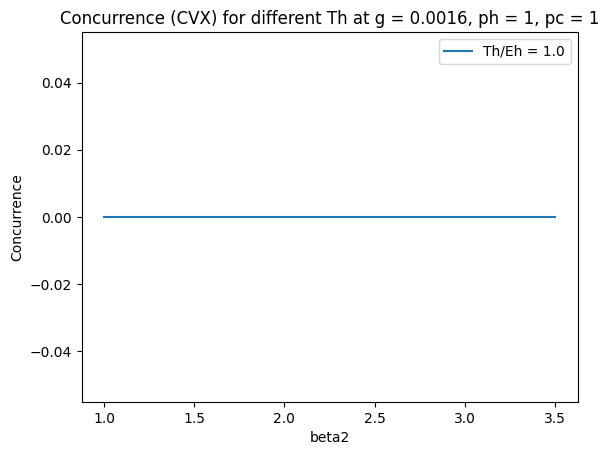

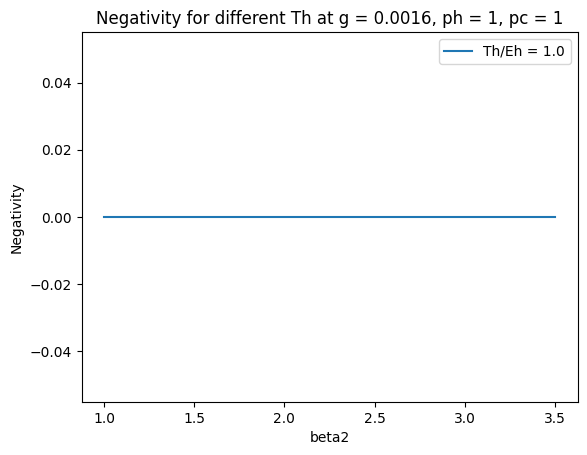

In [26]:
concurrence_plot(betalist,cvx_ss)
negativity_plot(betalist,cvx_ss)

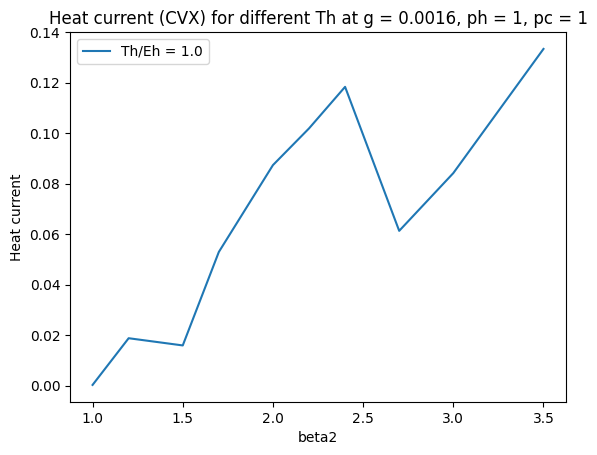

In [27]:
heat_current(betalist,cvx_ss)